In [1]:
from functools import partial
from ipywidgets import widgets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# to use bound function as callback in widgets.interact - this provides the function attribute __name__

class WrappablePartial(partial):

    @property
    def __module__(self):
        return self.func.__module__

    @property
    def __name__(self):
        return "functools.partial({}, *{}, **{})".format(
            self.func.__name__,
            self.args,
            self.keywords
        )

    @property
    def __doc__(self):
        return self.func.__doc__

# Aim

The aim is to replace a multi-U-pipe model of a ground-coupled heat exchanger by an equivalent concentric model.
The models are considered as equivalent when the same amount of heat is stored in the ground or released from 
the ground when the working fluid in the pipes is externally heated or cooled.

# Setup

## Double U-pipe
A ground-coupled heat exchanger consists of the following components: working fluid, pipe, grout, soil, and insulation layer. 
The volumina of these components must be equal in the original and the equivalent model. 
Then the heat capacities can be set as equal and both systems behave similarly in time.
If a double-U-pipe is replaced by a single concentric single pipe, the radius of the concentric pipe must be calculated. 
It holds 

\begin{equation}
r_{p1} = 2 {r_{p4}}
\end{equation}

where $r_{p4}$ is the inner pipe radius in the double-U-pipe model and $r_{p1}$ the inner pipe radius in the equivalent concentric model.

## Thermal and geometric properties

In [3]:
lambda_soil = 2.5  # thermal conductivity [W/m^2/K]
lambda_grout_4 = 2

capacity_grout = 3.9e6  # [J/K]
# capacity_soil = 2.5e6

r_g = 0.063  # grout radius [m]
r_p4 = 0.0167  # inner pipe radius in the double-U-pipe model [m]
r_e = 0.03536  # distance between pipe centre and grout centre [m]

In [4]:
def multiply_by_2(x):
    return 2 * x

r_p1 = multiply_by_2(r_p4)

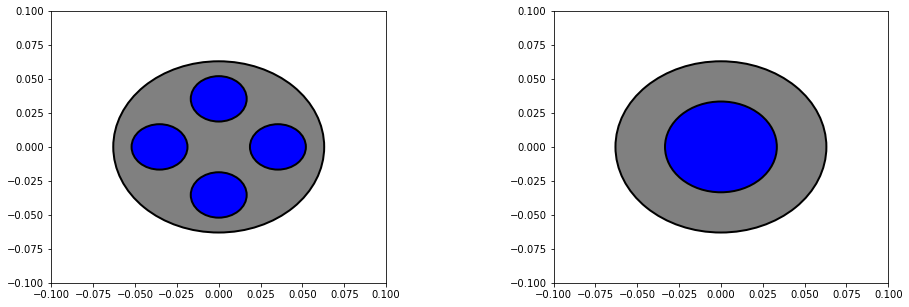

In [5]:
# draw grout and pipes in bird view - Double-U-pipe model and 1-pipe-concentric model

def draw_birdView_composite(r_g, r_p4, r_e, setting, function_adaptRadius):
     
    pipe_color = 'blue' if setting else 'red'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.subplots_adjust(wspace=.5)
    
    # 4 pipe
    ax1.set_xlim((-.1,.1))
    ax1.set_ylim((-.1,.1))
    
    ax1.add_patch(patches.Circle((0, 0), r_g, 
                                 facecolor='grey', edgecolor='black', linewidth=2))
    
    ax1.add_patch(patches.Circle((r_e, 0), r_p4, 
                                 facecolor=pipe_color, edgecolor='black', linewidth=2))
    ax1.add_patch(patches.Circle((-r_e, 0), r_p4, 
                                 facecolor=pipe_color, edgecolor='black', linewidth=2))
    ax1.add_patch(patches.Circle((0, r_e), r_p4, 
                                 facecolor=pipe_color, edgecolor='black', linewidth=2))
    ax1.add_patch(patches.Circle((0, -r_e), r_p4, 
                                 facecolor=pipe_color, edgecolor='black', linewidth=2))

    # 1 pipe
    ax2.set_xlim((-.1,.1))
    ax2.set_ylim((-.1,.1))

    ax2.add_patch(patches.Circle((0, 0), r_g, 
                                 facecolor='grey', edgecolor='black', linewidth=2))
    ax2.add_patch(patches.Circle((0, 0), function_adaptRadius(r_p4), 
                                 facecolor='blue', edgecolor='black', linewidth=2))
    
draw_birdView_composite(r_g, r_p4, r_e, True, multiply_by_2)

## Approach

The thermal condutivity in the Fick equation is calculated for the concentric model. 
This is done by using the constraint that the thermal flux between the working fluid in the conentric pipe and the soil surrounding the grout must equal the respective fluxes in the original double-U-pipe model.
The calculation is performed for two thermal regimes: steady-state and steady-flux (characterized  by a uniform, constant temperature increase at each point in the ground).

# Thermal resistance

Consider an array of long pipes grouted in a soil.
In first order, the relation between temperatures and heat flux reads

\begin{equation}
 T_f - T_b = R q
\end{equation}

where $T_f$ is a representative pipe fluid temperature, $T_b$ is the temperature in the soil outside the grout, 
$R$ is an effective fluid-to-soil thermal resistance (accounting for thermal interactions between pipe fluids and soil and the fluids in differerent pipes), and $q$ the total heat flux.

## Double-U-pipe system

A double-U-pipe heat exchanger has four pipes. 
The relation between temperatures and heat fluxes for four pipes reads [8.10 in Hellstroem, 1991]

\begin{equation}
T_{fm} - T_b = \sum_{n=1}^4 R_{mn} q_n  \qquad\qquad m = 1, ...,4
\end{equation}

where $T_f$ is fluid temperature in certain pipe denoted by $m$.
The total heat flux between the fluid in the four pipes and the soil $q$ is the sum of the fluxes from the individual pipes $q_n$

\begin{equation}
q = \sum_{n=1}^4 q_n
\end{equation}

The pipes interact thermally.
The effective fluid-to-soil thermal resistance $R_4$ (accounting for the heat fluxes between the four pipe fluids and between the four pipe fluids and the soil) is given by [8.19 in Hellstroem, 1991]

\begin{equation}
R_4 = \frac{  R_4^{\alpha} + 2R_4^{n} + R_4^{o} }{4}
\end{equation}

where $R^\alpha$ is resistances of fluid in a pipe with soil, $R^n$ is resistance due interaction with a neighboring pipe, and $R^o$ is resistance due to the opposing pipe. 

### Steady-state  in a composite region (grouted in soil)

The steady-state resistance between fluid in one pipe and the soil outside the grout is

\begin{equation}
R_4^\alpha = \frac 1{2\pi \lambda_{g4}} \left[ \ln\left(\frac{r_g}{r_{p4}}\right) - \sigma \ln\left(1-b^2\right) \right] + R_4^p
\end{equation}

where $R_4^p$ is the thermal resistance of the pipes,
$r_{p4}$ is the inner pipe radius in the double U-pipe model.
The resistance between fluids of two pipes is

\begin{equation}
R_4^\beta = -\frac 1{2\pi \lambda_{g4}} \left[ \ln\left(\frac{B_u^\beta}{r_g}\right) + \sigma \ln\left(b^\beta\right) \right]  \qquad\qquad \beta = [n, o]
\end{equation}

where

\begin{equation}
\sigma = \frac{\lambda_{g4} - \lambda_s} {\lambda_{g4} + \lambda_s},
\end{equation}

$\lambda_{g4}$ is the grout thermal conductivity, $\lambda_s$ is the soil thermal conductivity,

\begin{equation}
b^\beta = \sqrt{ \left(1 - b^2 \right)^2  + \left(\frac{B_u^\beta}{r_g}\right)^2 }
\end{equation}

$B_u^\beta$ are the distances between pipe centres, 

\begin{equation}
b= \frac{r_{e4}}{r_g}
\end{equation}

$r_{e}$ is the distance of the pipe centres from the grout centre, 
$r_g$ is the grout radius.

### Steady-flux in a homogeneous region

The resistances for a steady-flux regime read

\begin{eqnarray}
\tilde R_4^\alpha &=& \frac{1}{2\pi \tilde\lambda_{4}} \left[ \ln\left( \frac{r}{r_{p4}} \right) - \ln\left( 1 - b^2 \right) - 0.75 + b^2  \right] + \tilde R_4^p \\
\tilde R_4^\beta &=& -\frac{1}{2\pi \tilde\lambda_{4}} \left[  \ln\left( \frac{B_u^\beta}{r}\right) + \ln\left( b^\beta\right) + 0.75 - b^2  \right]
\end{eqnarray}

where $\lambda_4$ is total thermal conductivity (grout and soil), and $r$ is radius (where $T_b$ is measured).
The grout radius $r_g$ is used in the following when the grout conducitvity of the concentric pipe model is calculated.

The resistances for the double-U-pipe setup in the steady-state and steady-flux regime deviate considerably. The calculated steady-flux resistance is negative

In [6]:
def calculateResistance_4pipesCompositeRegion(lambda_grout_4, lambda_soil, 
                                              r_g, r_p4, r_e, 
                                              flag_steadyFlux, flag_output, flag_plot):
    
    sigma = (lambda_grout_4 - lambda_soil) / (lambda_grout_4 + lambda_soil)
 
    b = r_e / r_g
    # distance between (neighboring, opposing) pipes   - 'no'-variables are tuples
    B_u_no = np.array((np.sqrt(2) * r_e,  2 * r_e))
    # b_beta: neighboring, opposing
    b_no = np.sqrt(np.square( 1 - np.square(b)) + np.square(B_u_no/r_g))
        
    denominator = 2 * np.pi * lambda_grout_4
    
    steadyFluxCorrection = 0.75 - np.square(b) if flag_steadyFlux else 0
    
    # resistance between one pipe (T_fm) and area surounding grout (T_b)
    R_4_alpha = (np.log(r_g/r_p4) - sigma * np.log(1 - np.square(b)) - steadyFluxCorrection) / denominator
    # resistance between two pipes
    # R_b_beta: neighboring, opposing
    R_4_no = - ( np.log(B_u_no/r_g) + sigma * np.log(b_no) + steadyFluxCorrection) / denominator

    if flag_output:
        print("\tsigma: {}".format(sigma))
        print("\tB_u: {}".format(B_u_no))
        print("\tb_no: {}".format(b_no))
        print("\tR_4_alpha: {}".format(R_4_alpha))
        print("\tR_4_no: {}".format(R_4_no))
    if flag_plot:
        #     True: setting realistic
        flag_setting = False if r_e < r_p4 or r_e > r_g - r_p4 or r_p4 > B_u_no[0]/2 else True  
        draw_birdView_composite(r_g, r_p4, r_e, flag_setting, multiply_by_2)
    
    # 1. Interaction one pipe with area surounding grout and other pipes serial 
    #    (resistances added up) [8.19]
    # 2. 4 pipes in parallel (add up reciprocal resistances)
    return (R_4_alpha + 2 * R_4_no[0] + R_4_no[1]) / 4  # 2 neighboring and 1 opposing pipes
    #return 0.25 / (1/R_b_alpha + 2 / R_b_beta_tuple[0] + 1/R_b_beta_tuple[1]) # everything parallel
    
print("Steady-state:\n\tR_4 = {}".format(
    calculateResistance_4pipesCompositeRegion(
        lambda_grout_4, lambda_soil, r_g, r_p4, r_e, 
        flag_steadyFlux=False, flag_output=False, flag_plot=False)))

print("Steady-flux:\n\tR_4 = {}".format(
    calculateResistance_4pipesCompositeRegion(
        lambda_grout_4, lambda_soil, r_g, r_p4, r_e, 
        flag_steadyFlux=True, flag_output=False, flag_plot=False)))

Steady-state:
	R_4 = 0.03328312629128886
Steady-flux:
	R_4 = -0.0013311771245195572


An alternative formulation for the resistance of a double-U-pipe system reads [9.126 in Hellstroem, 1991]

\begin{equation}
\tilde R_4 = \frac{1}{2\pi \tilde\lambda_{4}} \left[ \ln\left( \frac{r}{r_{p4}}\right) - 0.75 + b^2 - 0.25 \ln\left( 1 - b^8 \right) - 0.5 \ln\left( \frac{\sqrt 2 br}{r_{p4}} - 0.25 \ln\left( \frac{2br}{r_{p4}} \right) \right) \right] + \frac{\tilde R_p} 4
\end{equation}


The calculation leads to another two values with the setup properties

In [7]:
def calculateResistance_4pipes_alternativeSteadyFluxFormulation(lambda_total, 
                                                                r_g, r_p4, r_e, r, 
                                                                flag_steadyFlux):
    
    b = r_e / r_g
    steadyFluxCorrection =  - 0.75 + np.square(b) if flag_steadyFlux else 0

    return ( np.log(r/r_p4) + steadyFluxCorrection - 0.25 * np.log( 1 - np.power(b, 8)) - 
            0.5 * np.log( np.sqrt(2)*b*r/r_p4 ) 
            - 0.25 * np.log(2 * b  * r / r_p4) )  / (2 * np.pi * lambda_total)

print("Steady-state:\n\tR_4 = {}".format(
    calculateResistance_4pipes_alternativeSteadyFluxFormulation(lambda_soil, 
                                                                r_g, r_p4, r_e, r_g, 
                                                                flag_steadyFlux=False)))
        
print("Steady-flux:\n\tR_4 = {}".format(
    calculateResistance_4pipes_alternativeSteadyFluxFormulation(lambda_soil, 
                                                                r_g, r_p4, r_e, r_g, 
                                                                flag_steadyFlux=True)))

Steady-state:
	R_4 = 0.02680152547334416
Steady-flux:
	R_4 = -0.0008899172593025738


---

The following conditions must be satisfied [with 9.126 in Hellstroem, 1991]:

1. $r_{p4} \ll r$
2. $B_u^\beta > 3 r_{p4}$
3. $r_{p4} < (1 - b)r$

Conditions 2. und 3. are satisfied by our setup. However, condition 1. is not. For low grout radii, e.g. the $r_g= 0.063$ from the setup, the calculated resistances are negative for the steady-flux regime. The values become positive for larger grout radii. 
Also the results obtained with both formulas for the steady-state regime agree better , e.g. if grout radius is doubled

In [8]:
def compareSteadyStateWithSteadyFlux_4pipesHomogeneousRegion(lambda_soil, r_p4, r_e, r_g):
    steady_state_alternative = calculateResistance_4pipes_alternativeSteadyFluxFormulation(lambda_soil, r_g, r_p4, r_e, r_g, True)
    steady_flux_alternative = calculateResistance_4pipes_alternativeSteadyFluxFormulation(lambda_soil, r_g, r_p4, r_e, r_g, False)
    
    print("Steady-state:")
    print("\t1. formula: \t\tR_4 = {}".format(calculateResistance_4pipesCompositeRegion(lambda_soil, lambda_soil, r_g, r_p4, r_e, True, False, False)))
    print("\tGenerall formula: \tR_4 = {}".format(steady_state_alternative))

    print("Steady-flux:")
    print("\t1. formula: \t\tR_4 = {}".format(calculateResistance_4pipesCompositeRegion(lambda_soil, lambda_soil, r_g, r_p4, r_e, False, False, False)))
    print("\tGenerall formula: \tR_4 = {}".format(steady_flux_alternative))
    
    print("\nRatio (Generall formula): {}".format(steady_state_alternative / steady_flux_alternative))
    
compareSteadyStateWithSteadyFlux_4pipesHomogeneousRegion(lambda_soil, r_p4, r_e, 2*r_g)

Steady-state:
	1. formula: 		R_4 = 0.02803840062875457
	Generall formula: 	R_4 = 0.028039012925816408
Steady-flux:
	1. formula: 		R_4 = 0.07077112350759271
	Generall formula: 	R_4 = 0.07077173580465457

Ratio (Generall formula): 0.3961894195051285


Hellstroem specifies condition 1 as $r_{p4} < \frac{r}{15}$  with formula 9.28, which can hardly be satisfied by the model (grout radius must be at least 25 cm). 
The calculations show that the resistances calculated for the steady-state and steady-flux regime disagree less for larger grout radii

In [9]:
bound_compareSteadyStateWithSteadyFlux_4pipesHomogeneousRegion = WrappablePartial(compareSteadyStateWithSteadyFlux_4pipesHomogeneousRegion, 
                                                                                  lambda_soil, r_p4, r_e)

widget_return = widgets.interact(bound_compareSteadyStateWithSteadyFlux_4pipesHomogeneousRegion, 
                                 r_g=widgets.FloatSlider(value=0.25, min=0.01, max=1., 
                                         step=0.01, readout_format='.2f')
                                )

Steady-state:
	1. formula: 		R_4 = 0.06791806644826823
	Generall formula: 	R_4 = 0.0679180689974344
Steady-flux:
	1. formula: 		R_4 = 0.11439097410329852
	Generall formula: 	R_4 = 0.11439097665246467

Ratio (Generall formula): 0.5937362455063105


## Concentric pipe

### Steady-state regime

The thermal resistance between fluid in a concentric pipe and the soil reads


\begin{equation}
R_1 = \frac{1}{2\pi \lambda_{g1}} \ln\left( \frac{r_g}{r_{p1}} \right) + R_1^p
\end{equation}

where $r_{p1}$ is the inner pipe radius, $\lambda_{g1}$ is the grout heat conductivity.

### Steady-flux regime

The thermal resistance is given by [9.28 in Hellstroem, 1991]

\begin{equation}
\tilde R_1 = \frac1 {2 \pi \lambda_{g1}} \left[ \ln\left( \frac{r_g}{r_{p1}}\right) - \frac 3 4 \right] + \tilde R_1^p
\end{equation}

where $\lambda_1$ is the thermal conductivity (soil and grout are equal), $r$ is a radius.
A more generall formula which is independent of condition 1. is provided by [9.29 in Hellstroem, 1991]

\begin{equation}
\tilde R_1 = \frac1 {2 \pi \lambda_{g1}} \left[ \left( \frac{r_g^2}{r_g^2 - r_{p1}^2} \right)^2 \ln\left( \frac{r_g}{r_{p1}}\right) - \frac 3 4 - \frac{r_{p1}^2}{2\left( r_g^2 - r_{p1}^2  \right)}  \right] + \tilde R_1^p
\end{equation}

Again the resistances calculated for the 1-pipe model deviate considerable for the setup properties. The values disagree less for higher grout radii, e.g. $r_g=0.25$

In [10]:
def calculateResistance_1pipe(lambda_grout_4, r_g, r_p1, flag_largeDistance, flag_steadyFlux):
    
    factor = 1 if flag_largeDistance else np.square( np.square(r_g) / (np.square(r_g) - np.square(r_p1)) )
    shift = 0 if flag_largeDistance else - 0.5 * np.square(r_p1) / (np.square(r_g) - np.square(r_p1))
    
    steadyFluxCorrection = 0.75 if flag_steadyFlux else 0
    
    return (factor * np.log(r_g / r_p1) 
            - steadyFluxCorrection + shift) / (2 * np.pi * lambda_grout_4)


def compareResistances_1pipe(lambda_grout_4, r_p1, r_g):
    print("\tSteady-state:\t\t\tR1 = {}".format(calculateResistance_1pipe(lambda_grout_4, r_g, r_p1, False, False)))
    print("\tSteady-flux - 1st formula:\tR1 = {}".format(calculateResistance_1pipe(lambda_grout_4, r_g, r_p1, True, True)))
    print("\tSteady-flux - Generall formula:\tR1 = {}".format(calculateResistance_1pipe(lambda_grout_4, r_g, r_p1, False, True)))
    
print("r_g = {}:".format(r_g))
compareResistances_1pipe(lambda_grout_4, r_p1, r_g)
print("r_g = 0.25:")
compareResistances_1pipe(lambda_grout_4, r_p1, 0.25)

print("r_g = 1.:")
compareResistances_1pipe(lambda_grout_4, r_p1, 1)

r_g = 0.063:
	Steady-state:			R1 = 0.08214580501597303
	Steady-flux - 1st formula:	R1 = -0.0091849251572474
	Steady-flux - Generall formula:	R1 = 0.02246270135651228
r_g = 0.25:
	Steady-state:			R1 = 0.16533377944924477
	Steady-flux - 1st formula:	R1 = 0.10049878812554773
	Steady-flux - Generall formula:	R1 = 0.105650675789784
r_g = 1.:
	Steady-state:			R1 = 0.27105978423422306
	Steady-flux - 1st formula:	R1 = 0.21081658820187354
	Steady-flux - Generall formula:	R1 = 0.21137668057476233


In [11]:
bound_compareResistances_1pipe = WrappablePartial(compareResistances_1pipe, lambda_grout_4, r_p1)

widget_return = widgets.interact(bound_compareResistances_1pipe, 
                                 # grout radius
                                 r_g=widgets.FloatSlider(value=r_g, min=0.01, max=1., 
                                         step=0.001, readout_format='.3f')
                                )

	Steady-state:			R1 = 0.08214580501597303
	Steady-flux - 1st formula:	R1 = -0.0091849251572474
	Steady-flux - Generall formula:	R1 = 0.02246270135651228


# Calculating the grout thermal conductivity for the concentric pipe model to replace the double-U-pipe model

The equivalent grout thermal conductivity $\lambda_{g1}$ is calculated by setting

\begin{equation}
R_1 = R_4
\end{equation}

### Steady-state regime

The formula is

\begin{equation}
\lambda_{g1} = \frac 1 {2\pi R_4} \ln\left( \frac{r_g}{r_{p1}} \right)
\end{equation}

### Steady-flux regime

It becomes

\begin{equation}
\tilde\lambda_{g1} = \frac 1 {2\pi \tilde R_4} \left[\ln\left( \frac{r_g}{r_{p1}} \right) - \frac 3 4 \right]
\end{equation}


In [12]:
def calculateEquivalentConductivity(function_R4, function_r_p, flag_plot, lambda_grout_4, lambda_soil, 
                                    r_g, r_p4, r_e):

    for flag_steadyFlux in [False, True]:
        print("Steady-flux:") if flag_steadyFlux else print("Steady-state:")
        
        R_b4 = function_R4(lambda_grout_4, lambda_soil, r_g, r_p4, r_e, 
                           flag_steadyFlux, True, flag_plot and not flag_steadyFlux)
        print(R_b4)
        r_p1 = function_r_p(r_p4)  # setting area equal
        print("\tr_p1: {}".format(r_p1))

        steadyFluxCorrection =  - 0.75 if flag_steadyFlux else 0

        conductivity = (np.log(r_g/r_p1) + steadyFluxCorrection)  / (2 * np.pi * R_b4)
        print("\tGrout conductivity lambda_g1: {}".format(conductivity))

The calculated thermal conductivities for the steady-state and steady-flux regime disagree with the geometric properties in the setup

In [13]:
calculateEquivalentConductivity(calculateResistance_4pipesCompositeRegion, multiply_by_2, False, 
                                lambda_grout_4, lambda_soil, r_g, r_p4, r_e)

Steady-state:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.04844648  1.31502383]
	R_4_alpha: 0.10231154228379657
	R_4_no: [ 0.0187991  -0.00677725]
0.0332831262913
	r_p1: 0.0334
	Grout conductivity lambda_g1: 3.0344612498393917
Steady-flux:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.04844648  1.31502383]
	R_4_alpha: 0.06769723886798816
	R_4_no: [-0.0158152  -0.04139155]
-0.00133117712452
	r_p1: 0.0334
	Grout conductivity lambda_g1: 13.799704018445153


They get close for higher grout radii, e.g. for  $r_g = 0.25$

In [14]:
calculateEquivalentConductivity(calculateResistance_4pipesCompositeRegion, multiply_by_2, False, 
                                lambda_grout_4, lambda_soil, 0.25, r_p4, r_e)

Steady-state:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.00020009  1.02000527]
	R_4_alpha: 0.21516211309071562
	R_4_no: [ 0.12806628  0.1006602 ]
0.142988717275
	r_p1: 0.0334
	Grout conductivity lambda_g1: 2.2404829533068837
Steady-flux:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.00020009  1.02000527]
	R_4_alpha: 0.15707097852192775
	R_4_no: [ 0.06997514  0.04256906]
0.0848975827063
	r_p1: 0.0334
	Grout conductivity lambda_g1: 2.3675300266967074


Steady-state:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.04844648  1.31502383]
	R_4_alpha: 0.10231154228379657
	R_4_no: [ 0.0187991  -0.00677725]
0.0332831262913
	r_p1: 0.0334
	Grout conductivity lambda_g1: 3.0344612498393917
Steady-flux:
	sigma: -0.1111111111111111
	B_u: [ 0.05000659  0.07072   ]
	b_no: [ 1.04844648  1.31502383]
	R_4_alpha: 0.06769723886798816
	R_4_no: [-0.0158152  -0.04139155]
-0.00133117712452
	r_p1: 0.0334
	Grout conductivity lambda_g1: 13.799704018445153


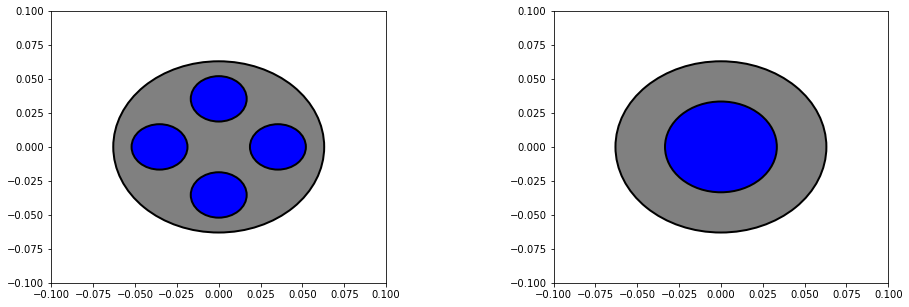

In [15]:
compareCalculatedEquivalentConductivity = WrappablePartial(calculateEquivalentConductivity, 
                                                              calculateResistance_4pipesCompositeRegion, 
                                                              multiply_by_2, True)



widget_return = widgets.interact(compareCalculatedEquivalentConductivity, 
                                 # grout heat conductivity
                                 lambda_grout_4=widgets.FloatSlider(value=lambda_grout_4, min=1, max=4, 
                                              step=0.1, readout_format='.1f'),
                                 # soil heat conductivity
                                 lambda_soil=widgets.FloatSlider(value=lambda_soil, min=1, max=4, 
                                              step=0.1, readout_format='.1f'),
                                 # grout radius
                                 r_g=widgets.FloatSlider(value=r_g, min=0.01, max=1., 
                                         step=0.001, readout_format='.3f'),
                                 # pipe radius
                                 r_p4=widgets.FloatSlider(value=r_p4, min=0.01, max=0.1, 
                                           step=0.0001, readout_format='.4f'),   
                                 # position of pipe centers (radius)
                                 r_e=widgets.FloatSlider(value=r_e, min=0.01, max=0.05, 
                                                  step=0.00001, readout_format='.5f')
                                )

## Time to reach the steady-flux regime

The time to reach after a change in the heat injection rate the steady-flux regime is estimated as [9.4 in Hellstroem, 1991] 

\begin{equation}
t = \frac{0.2 r^2}{a}, \qquad\qquad a=\frac{\lambda}{C}
\end{equation}

In [17]:
def calculateTimeForStreadyFluxRegime(lambda_total, capacity_total, r):
    return 0.2 * np.square(r) * capacity_total / lambda_total


calculateTimeForStreadyFluxRegime_grout = WrappablePartial(calculateTimeForStreadyFluxRegime, 
                                                           lambda_grout_4, capacity_grout)

widget_return = widgets.interact(calculateTimeForStreadyFluxRegime_grout, 
                                 r=widgets.FloatSlider(value=0.063, min=0.01, max=1., 
                                         step=0.01, readout_format='.3f')
                                )

1547.9100000000003

# Conclusion

The equivalent thermal conductivity needed to replace a multi-U-pipe model by a concentric model cannot be calculated with the aforementioned formulas for the given setup.
The reason is condition 1. in the calculation of the thermal resistance $R_4$ of the double-U-pipe model. 
However, the equivalent thermal conductivity can be calculated for larger grout radii.